In [1]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import plotly.express as px

import os
os.environ['R_HOME'] = '/Users/chloecho/anaconda3/envs/cornell_dev/lib/R'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from fitter import Fitter
from pymer4.models import Lm
from pymer4.models import Lmer

# Import Data

In [2]:
scm_counts = pd.read_csv("Data/2022_scm_counts.csv")
scm_counts = scm_counts.melt(id_vars="Field_ID").rename(
    columns={"Field_ID": "recordId", "variable": "Week", "value": "Count"}
)
scm_counts = clean_columns(scm_counts)
scm_counts['week']=scm_counts['week'].astype(int)
scm_counts


,record_id,week,count
0,DEG_DIE_100,17,100.0
1,DEG_DIE_ERSWC,17,80.0
2,DEG_DIE_SH,17,64.0
3,DEG_EVA_PGREEN,17,7.0
4,DEG_FES_OVO4,17,25.0
...,...,...,...
585,WIS_COO_2,26,NaN
586,WIS_KEN,26,NaN
587,WIS_WAL,26,NaN
588,ZUE_PED,26,NaN


### Climate

In [3]:
climate = pd.read_csv("Data/2022_scm_climate.csv")
climate = clean_columns(climate)
climate["record_id"].replace("-", "_", regex=True)
climate


,record_id,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,ave_temp_c
0,DEG_DIE_100,1-Jan-22,51,32,41.5,0.07,10.6,0.0,5.3
1,DEG_DIE_100,2-Jan-22,49,28,38.5,0.22,9.4,-2.2,3.6
2,DEG_DIE_100,3-Jan-22,31,10,20.5,0.05,-0.6,-12.2,-6.4
3,DEG_DIE_100,4-Jan-22,16,8,12.0,0.00,-8.9,-13.3,-11.1
4,DEG_DIE_100,5-Jan-22,30,15,22.5,0.00,-1.1,-9.4,-5.3
...,...,...,...,...,...,...,...,...,...
14294,ZUE_REE,26-Jun-22,85,63,74.0,0.00,29.4,17.2,23.3
14295,ZUE_REE,27-Jun-22,88,63,75.5,0.38,31.1,17.2,24.2
14296,ZUE_REE,28-Jun-22,72,52,62.0,0.00,22.2,11.1,16.7
14297,ZUE_REE,29-Jun-22,72,51,61.5,0.00,22.2,10.6,16.4


In [4]:
climate["date"] = pd.to_datetime(climate["date"])
climate["week"] = climate["date"].dt.strftime("%U").astype(int) + 1
climate = clean_columns(climate)
climate["record_id"] = climate["record_id"].str.replace("-", "_")
climate


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_74829/3591429956.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  climate["date"] = pd.to_datetime(climate["date"])


,record_id,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,ave_temp_c,week
0,DEG_DIE_100,2022-01-01,51,32,41.5,0.07,10.6,0.0,5.3,1
1,DEG_DIE_100,2022-01-02,49,28,38.5,0.22,9.4,-2.2,3.6,2
2,DEG_DIE_100,2022-01-03,31,10,20.5,0.05,-0.6,-12.2,-6.4,2
3,DEG_DIE_100,2022-01-04,16,8,12.0,0.00,-8.9,-13.3,-11.1,2
4,DEG_DIE_100,2022-01-05,30,15,22.5,0.00,-1.1,-9.4,-5.3,2
...,...,...,...,...,...,...,...,...,...,...
14294,ZUE_REE,2022-06-26,85,63,74.0,0.00,29.4,17.2,23.3,27
14295,ZUE_REE,2022-06-27,88,63,75.5,0.38,31.1,17.2,24.2,27
14296,ZUE_REE,2022-06-28,72,52,62.0,0.00,22.2,11.1,16.7,27
14297,ZUE_REE,2022-06-29,72,51,61.5,0.00,22.2,10.6,16.4,27


Aggregate climate data into weekly averages to be used with weekly SCM counts. 

In [5]:
weekly_climate = climate.groupby(["record_id", "week"]).mean()
weekly_climate = weekly_climate.reset_index()
weekly_climate = clean_columns(weekly_climate)
weekly_climate["record_id"] = weekly_climate["record_id"].str.replace("-", "_")
weekly_climate


,record_id,week,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,ave_temp_c
0,DEG_DIE_100,1,2022-01-01,51.000000,32.000000,41.500000,0.070000,10.600000,0.000000,5.300000
1,DEG_DIE_100,2,2022-01-05,30.000000,15.000000,22.500000,0.065714,-1.128571,-9.442857,-5.285714
2,DEG_DIE_100,3,2022-01-12,29.285714,7.142857,18.214286,0.050000,-1.500000,-13.800000,-7.657143
3,DEG_DIE_100,4,2022-01-19,22.571429,0.571429,11.571429,0.130000,-5.242857,-17.471429,-11.371429
4,DEG_DIE_100,5,2022-01-26,21.428571,-9.000000,6.214286,0.018571,-5.871429,-22.771429,-14.342857
...,...,...,...,...,...,...,...,...,...,...
2128,ZUE_REE,23,2022-06-01,77.428571,56.714286,67.071429,0.081429,25.242857,13.742857,19.471429
2129,ZUE_REE,24,2022-06-08,70.857143,53.142857,62.000000,0.128571,21.600000,11.757143,16.671429
2130,ZUE_REE,25,2022-06-15,78.142857,57.142857,67.642857,0.215714,25.642857,13.957143,19.814286
2131,ZUE_REE,26,2022-06-22,77.142857,54.714286,65.928571,0.087143,25.100000,12.614286,18.828571


### Soil Data - From Lab Samples

In [6]:
soil_lab = pd.read_csv("Data/2022_soil_lab_analysis.csv")
soil_lab = clean_columns(soil_lab)
soil_lab = soil_lab.rename(columns={"field_id": "record_id"})
soil_lab["record_id"] = soil_lab["record_id"].str.replace("-", "_")
soil_lab


,record_id,organic_matter,base_saturation_ca,base_saturation_mg,base_saturation_k,base_saturation_na,base_saturation_h,base_saturation_total,exch_acidity,buffer_p_h,...,p_ppm,mg_ppm,k_ppm,na_ppm,zn_ppm,al_ppm,morgan_p_lb_a,morgan_k_lb_a,morgan_ca_lb_a,morgan_mg_lb_a
0,DEG_DIE_100,3.87,89.8,4.8,2.4,0.8,2.2,97.8,0.44,6.49,...,146.0,116.0,186.0,36.0,2.9,1093.0,31.6,330.2,6743.1,210.5
1,DEG_DIE_ERSWC,4.64,64.1,10.6,4.1,0.9,20.4,79.6,2.40,6.00,...,208.0,152.0,188.0,24.0,5.4,1149.0,18.8,333.0,2656.2,274.7
2,DEG_DIE_SH,5.46,82.8,12.2,3.8,1.2,0.0,100.0,0.00,0.00,...,41.0,179.0,180.0,34.0,1.6,1012.0,1.3,319.1,3628.5,324.7
3,DEG_EVA_PGREEN,6.69,86.9,9.3,2.5,1.3,0.0,100.0,0.00,0.00,...,49.0,185.0,160.0,51.0,2.9,949.0,6.3,283.4,5320.2,335.5
4,DEG_FES_OVO4,4.70,81.8,13.5,2.9,1.8,0.0,100.0,0.00,0.00,...,78.0,238.0,166.0,60.0,5.1,735.0,20.2,293.8,4369.6,431.9
5,DEG_FOU_ELM,6.21,64.8,16.2,4.8,2.7,11.6,88.4,1.48,6.23,...,106.0,252.0,241.0,78.0,10.5,891.0,16.8,426.6,2954.6,457.4
6,DEG_HAI_ACROSSROAD,5.54,85.5,10.5,2.5,1.5,0.0,100.0,0.00,0.00,...,97.0,196.0,149.0,53.0,3.7,672.0,33.9,264.3,4849.8,355.7
7,DEG_MCM_CH,6.12,71.1,22.0,4.2,2.8,0.0,100.0,0.00,0.00,...,99.0,322.0,196.0,78.0,3.6,1074.0,9.0,347.3,3061.3,584.2
8,DEG_MCM_W7,7.42,81.4,12.0,4.4,2.2,0.0,100.0,0.00,0.00,...,250.0,281.0,329.0,99.0,14.1,805.0,85.8,581.3,5877.5,510.1
9,DEG_STR_1,6.18,74.6,13.8,1.1,1.3,9.2,90.8,1.08,6.33,...,57.0,196.0,49.0,35.0,1.8,1036.0,3.0,87.3,3120.6,355.7


### Soil Data - From Soil Map

In [7]:
soil_map = pd.read_csv("Data/2022_soil_map.csv")
soil_map = clean_columns(soil_map)
soil_map = soil_map.rename(columns={"field_id_soil_survey_ws": "record_id"})
soil_map["record_id"] = soil_map["record_id"].str.replace("-", "_")
soil_map


,record_id,x_coordinate,y_coordinate,corn_area_m_2,muid,state,awc,clay,kffact,om,perm,thick,hygrp,drain,slope,ll,ifhydric,afldfreq
0,DEG_DIE_100,42.556020,-76.244470,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
1,DEG_DIE_ERSWC,42.634690,-76.128060,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
2,DEG_DIE_SH,42.571300,-76.082880,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
3,DEG_EVA_PGREEN,42.515120,-76.162020,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
4,DEG_FES_OVO4,42.839830,-76.297810,High,NY128,NY,0.12,19.2,0.31,1.0,0.66,67.7,2.1,3.6,8.3,23.9,0.0,4.0
5,DEG_FOU_ELM,42.586390,-76.280200,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
6,DEG_HAI_ACROSSROAD,42.557160,-76.277660,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0
7,DEG_MCM_CH,42.642000,-76.203540,Medium,NY127,NY,0.08,13.1,0.30,0.9,0.71,57.7,3.0,3.4,16.4,24.2,0.0,4.0
8,DEG_MCM_W7,42.700510,-76.231370,Medium,NY134,NY,0.08,11.3,0.25,0.8,7.45,66.1,1.7,3.3,5.2,23.9,0.1,3.4
9,DEG_STR_1,42.705340,-76.083620,Medium,NY126,NY,0.08,19.4,0.30,1.0,0.66,52.7,3.1,4.0,15.4,28.2,0.0,4.0


### Landscape Data - 500m Radius

In [8]:
scm_cdl_500 = pd.read_csv("Landscape/2022_scm_cdl_500m.csv")
scm_cdl_500 = clean_columns(scm_cdl_500)
scm_cdl_500 = scm_cdl_500.rename(columns={"site_id": "record_id"})
scm_cdl_500


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,97,0,0,36,28,23,3,6,14,...,673,0.493040,31,0.022711,52,0.038095,96,0.070330,0,0.000000
1,STA_PAD,297,1,0,63,37,5,0,1,16,...,591,0.431702,21,0.015340,138,0.100804,106,0.077429,1,0.000730
2,STA_CRA,24,0,0,74,18,4,0,3,65,...,440,0.321402,137,0.100073,155,0.113221,99,0.072316,0,0.000000
3,POV_DUN,6,0,0,64,12,0,0,0,220,...,16,0.011730,391,0.286657,301,0.220674,76,0.055718,0,0.000000
4,DEG_FES_OVO4,341,0,0,46,46,3,0,0,81,...,576,0.421053,98,0.071637,72,0.052632,95,0.069444,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,3,0,0,58,36,7,0,0,306,...,8,0.005844,495,0.361578,235,0.171658,101,0.073776,0,0.000000
76,HAT,79,0,0,43,28,11,14,10,287,...,108,0.079063,456,0.333821,183,0.133968,106,0.077599,0,0.000000
77,MOO,248,0,0,31,16,4,0,0,85,...,481,0.352381,131,0.095971,176,0.128938,51,0.037363,0,0.000000
78,URI,207,12,0,11,44,14,1,0,120,...,595,0.434942,126,0.092105,47,0.034357,70,0.051170,12,0.008772


### Landscape Data - 1000m Radius

In [9]:
scm_cdl_1000 = pd.read_csv("Landscape/2022_scm_cdl_1000m.csv")
scm_cdl_1000 = clean_columns(scm_cdl_1000)
scm_cdl_1000 = scm_cdl_1000.rename(columns={"site_id": "record_id"})
scm_cdl_1000


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,599,1,3,114,65,30,3,7,179,...,2387,0.534363,256,0.057309,280,0.062682,219,0.049026,1,0.000224
1,STA_PAD,907,1,0,398,318,31,6,1,353,...,1539,0.344913,521,0.116764,617,0.138279,754,0.168983,1,0.000224
2,STA_CRA,180,0,0,163,42,11,2,5,650,...,1426,0.319516,1152,0.258122,498,0.111584,223,0.049966,0,0.000000
3,POV_DUN,10,4,0,315,105,26,5,6,960,...,93,0.020838,1678,0.375980,913,0.204571,457,0.102397,4,0.000896
4,DEG_FES_OVO4,962,0,0,151,89,12,1,0,899,...,1809,0.404970,989,0.221401,273,0.061115,253,0.056638,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,10,9,1,287,173,41,2,2,931,...,26,0.005822,1771,0.396552,1020,0.228392,505,0.113077,9,0.002015
76,HAT,166,1,8,117,117,59,62,28,1204,...,653,0.145954,1756,0.392490,612,0.136790,383,0.085606,1,0.000224
77,MOO,706,6,2,192,102,22,1,1,545,...,1418,0.317013,792,0.177062,734,0.164096,318,0.071093,6,0.001341
78,URI,710,15,0,58,91,21,1,0,344,...,2599,0.581302,397,0.088794,208,0.046522,171,0.038246,15,0.003355


### Landscape Data - 2000m Radius

In [10]:
scm_cdl_2000 = pd.read_csv("Landscape/2022_scm_cdl_2000m.csv")
scm_cdl_2000 = clean_columns(scm_cdl_2000)
scm_cdl_2000 = scm_cdl_2000.rename(columns={"site_id": "record_id"})
scm_cdl_2000


,record_id,corn,open_water,sweet_corn,developed_open_space,developed_low_intensity,developed_med_intensity,developed_high_intensity,barren,deciduous_forest,...,ag,ag_prop,nat,nat_prop,semi_nat,semi_nat_prop,dev,dev_prop,other,other_prop
0,STA_LOT,2857,3,10,810,506,134,30,17,1228,...,8611,0.542664,1958,0.123393,1109,0.069889,1497,0.094341,3,0.000189
1,STA_PAD,2626,5,1,1124,715,63,6,9,2721,...,4585,0.288983,3923,0.247258,3059,0.192802,1917,0.120824,5,0.000315
2,STA_CRA,1550,11,0,689,217,34,7,7,3241,...,4343,0.273644,6034,0.380190,2069,0.130364,954,0.060110,11,0.000693
3,POV_DUN,88,78,2,1221,408,94,21,123,3835,...,521,0.032850,7209,0.454540,3400,0.214376,1867,0.117718,78,0.004918
4,DEG_FES_OVO4,2245,0,2,756,267,31,9,5,4703,...,4737,0.298525,5608,0.353416,1838,0.115831,1068,0.067305,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,YOU,75,25,3,886,664,112,5,5,4110,...,158,0.009959,7733,0.487425,3870,0.243933,1672,0.105389,25,0.001576
76,HAT,496,1,8,680,640,220,113,31,4763,...,3374,0.212669,5805,0.365900,2360,0.148755,1684,0.106146,1,0.000063
77,MOO,2316,11,6,490,507,133,23,3,2524,...,4380,0.276132,3751,0.236477,3202,0.201866,1156,0.072879,11,0.000693
78,URI,2497,19,263,257,372,75,21,10,2178,...,8424,0.530947,2785,0.175533,1365,0.086033,735,0.046325,19,0.001198


# Preliminary Models

[clustimage] >WARNING> SKIPPED _fit distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED kstwo distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED rv_continuous distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED rv_histogram distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED kappa4 distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED levy_stable distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED vonmises_fisher distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED ncx2 distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED recipinvgauss distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED skewnorm distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED studentized_range distribution (taking more than 30 seconds)
[clustimage] >WARNING> SKIPPED triang distribution (taking more tha

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.000009,3554.413696,3569.729479,inf,0.080421,0.023239
powerlognorm,0.000009,2023.824718,2039.140501,inf,0.038855,0.668880
burr12,0.000011,1955.814424,1971.130206,inf,0.024773,0.981899
halfgennorm,0.000011,2043.539381,2055.026218,inf,0.050054,0.350240
pareto,0.000011,1985.851893,1997.338729,inf,0.028251,0.941807


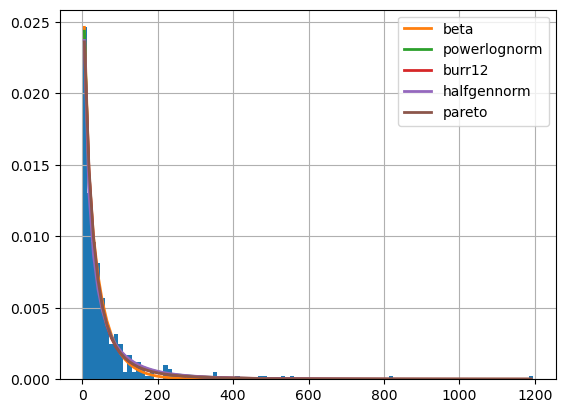

In [35]:
f = Fitter(scm_counts['count'].dropna())
f.fit()
f.summary()

### Climate

Merged dataframe for SCM counts and climate variables. 

In [11]:
scm_climate_model = pd.merge(scm_counts, weekly_climate, on=['record_id', 'week'], how = 'left')
scm_climate_model = scm_climate_model.dropna()
scm_climate_model

,record_id,week,count,date,max_temp_f,min_temp_f,ave_temp_f,rain_inches,max_temp_c,min_temp_c,ave_temp_c
0,DEG_DIE_100,17,100.0,2022-04-20,45.571429,30.142857,37.857143,0.212857,7.542857,-1.028571e+00,3.271429
1,DEG_DIE_ERSWC,17,80.0,2022-04-20,44.714286,29.714286,37.214286,0.297143,7.057143,-1.257143e+00,2.914286
2,DEG_DIE_SH,17,64.0,2022-04-20,44.285714,29.142857,36.714286,0.310000,6.814286,-1.585714e+00,2.628571
3,DEG_EVA_PGREEN,17,7.0,2022-04-20,45.000000,29.714286,37.357143,0.250000,7.228571,-1.257143e+00,2.985714
4,DEG_FES_OVO4,17,25.0,2022-04-20,48.285714,32.000000,40.142857,0.181429,9.042857,6.344132e-17,4.514286
...,...,...,...,...,...,...,...,...,...,...,...
505,ONE_STA_1,25,47.0,2022-06-15,80.000000,55.142857,67.571429,0.067143,26.685714,1.284286e+01,19.771429
516,SMI_JOH_1,25,52.0,2022-06-15,77.857143,54.571429,66.214286,0.190000,25.457143,1.255714e+01,19.014286
518,SMI_KEL,25,8.0,2022-06-15,79.428571,56.142857,67.785714,0.081429,26.342857,1.341429e+01,19.871429
575,SMI_JOH_1,26,75.0,2022-06-22,74.428571,50.142857,62.285714,0.000000,23.585714,1.010000e+01,16.814286


Simple linear model with climate variables. 

In [12]:
formula = "count ~ max_temp_f + min_temp_f + rain_inches"
md = smf.mixedlm(formula, scm_climate_model, groups=scm_climate_model["record_id"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: count     
No. Observations:   329     Method:             REML      
No. Groups:         57      Scale:              9367.5417 
Min. group size:    2       Log-Likelihood:     -1986.7240
Max. group size:    8       Converged:          Yes       
Mean group size:    5.8                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept     47.688   47.854  0.997 0.319 -46.105 141.480
max_temp_f    -3.531    1.314 -2.686 0.007  -6.107  -0.954
min_temp_f     5.584    1.538  3.632 0.000   2.571   8.598
rain_inches   27.514   61.994  0.444 0.657 -93.991 149.019
Group Var   2655.023    9.294                             



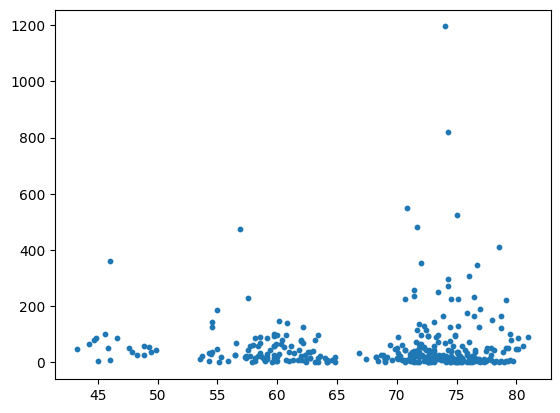

In [13]:
plt.scatter(scm_climate_model['max_temp_f'], scm_climate_model['count'], s=10)

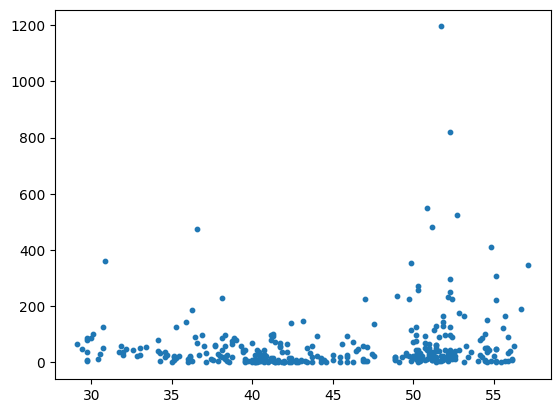

In [14]:
plt.scatter(scm_climate_model['min_temp_f'], scm_climate_model['count'], s=10)

In [18]:
model = Lm("count ~ min_temp_f + max_temp_f + rain_inches +(1 | record_id) ", data=scm_climate_model)
display(model.fit())

PatsyError: Error evaluating factor: TypeError: Cannot perform 'ror_' with a dtyped [object] array and scalar of type [bool]
    count~min_temp_f+max_temp_f+rain_inches+(1|record_id)
                                            ^^^^^^^^^^^^^

<Axes: xlabel='fits', ylabel='count'>

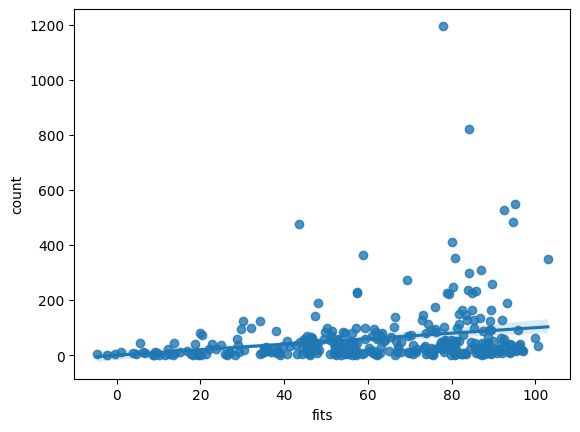

In [16]:
sns.regplot(x="fits", y="count", data=model.data, fit_reg=True)

In [19]:
model = Lmer("count ~ min_temp_f + max_temp_f + rain_inches + (1|record_id)", data=scm_climate_model)
display(model.fit())

: 

: 

### 500m Radius

In [ ]:
scm_500 = pd.merge(
    scm_counts,
    scm_cdl_500[
        ["recordId", "Ag_Prop", "Nat_Prop", "Semi_Nat_Prop", "Dev_Prop", "Other_Prop"]
    ],
    on="recordId",
    how="left",
)
scm_500


,recordId,Week,Count,Ag_Prop,Nat_Prop,Semi_Nat_Prop,Dev_Prop,Other_Prop
0,DEG_DIE_100,17,100.0,0.244868,0.278592,0.057918,0.037390,0.000000
1,DEG_DIE_ERSWC,17,80.0,0.255490,0.180820,0.100293,0.056369,0.000732
2,DEG_DIE_SH,17,64.0,0.192251,0.136696,0.222222,0.052632,0.000731
3,DEG_EVA_PGREEN,17,7.0,0.202050,0.106149,0.234993,0.041728,0.000000
4,DEG_FES_OVO4,17,25.0,0.421053,0.071637,0.052632,0.069444,0.000000
...,...,...,...,...,...,...,...,...
585,WIS_COO_2,26,NaN,0.267740,0.072421,0.220190,0.016094,0.000732
586,WIS_KEN,26,NaN,0.054212,0.221245,0.106227,0.210989,0.038095
587,WIS_WAL,26,NaN,0.073099,0.424708,0.065789,0.059942,0.000000
588,ZUE_PED,26,NaN,0.350954,0.154185,0.074156,0.035977,0.000000


In [ ]:
formula = "Proportion ~ Management + Weather + Stage"
md = smf.mixedlm(formula, egg_data, groups=egg_data["Site"])
mdf = md.fit()
print(mdf.summary())
